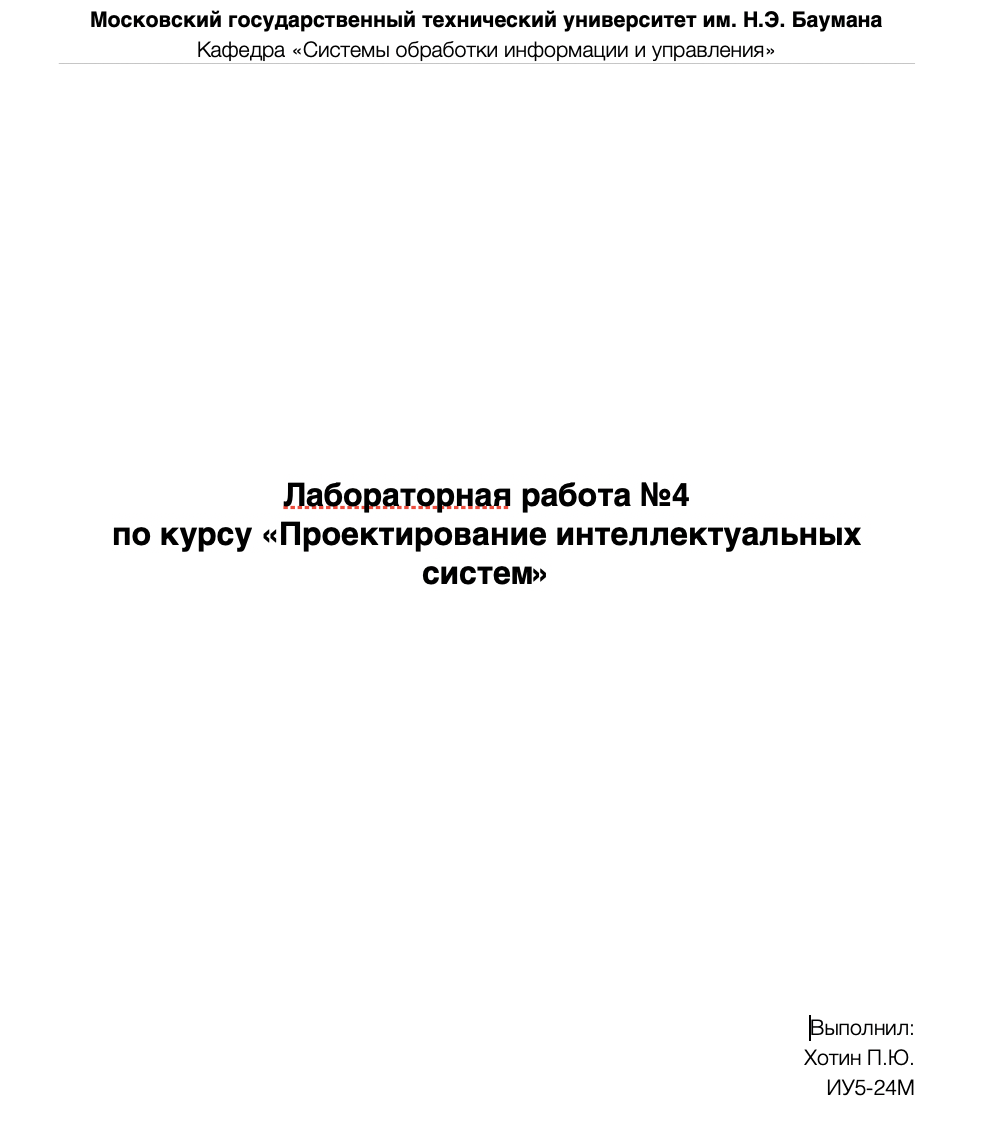

In [1]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras.constraints import maxnorm
from keras.optimizers import SGD

Using TensorFlow backend.


In [13]:
from keras.callbacks import ModelCheckpoint, TensorBoard
import datetime

In [3]:
batch_size = 32
num_classes = 10
epochs = 5
num_predictions = 20

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


**Создание базовой модели**

In [5]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [6]:
model = create_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
______________________________________

**Создание колбеков для чекпоинтов и тензорборда**

In [19]:
checkpoint_path = "training_chekpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Создаем коллбек сохраняющий веса модели
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1, period=1)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [20]:
model.fit(x_train,
          y_train,
          validation_data=(x_test, y_test),
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[cp_callback, tensorboard_callback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 144s 3ms/step - loss: 1.3515 - accuracy: 0.5139 - val_loss: 1.2078 - val_accuracy: 0.5714

Epoch 00001: saving model to training_chekpoints/cp.ckpt

Epoch 2/5
50000/50000 [==============================] - 148s 3ms/step - loss: 1.2331 - accuracy: 0.5586 - val_loss: 1.1382 - val_accuracy: 0.5968

Epoch 00002: saving model to training_chekpoints/cp.ckpt
Epoch 3/5
50000/50000 [==============================] - 150s 3ms/step - loss: 1.1496 - accuracy: 0.5888 - val_loss: 1.0749 - val_accuracy: 0.6157

Epoch 00003: saving model to training_chekpoints/cp.ckpt
Epoch 4/5
50000/50000 [==============================] - 148s 3ms/step - loss: 1.0878 - accuracy: 0.6127 - val_loss: 1.0217 - val_accuracy: 0.6399

Epoch 00004: saving model to training_chekpoints/cp.ckpt
Epoch 5/5
50000/50000 [==============================] - 148s 3ms/step - loss: 1.0385 - accuracy: 0.6314 - val_loss: 0.9857 - val

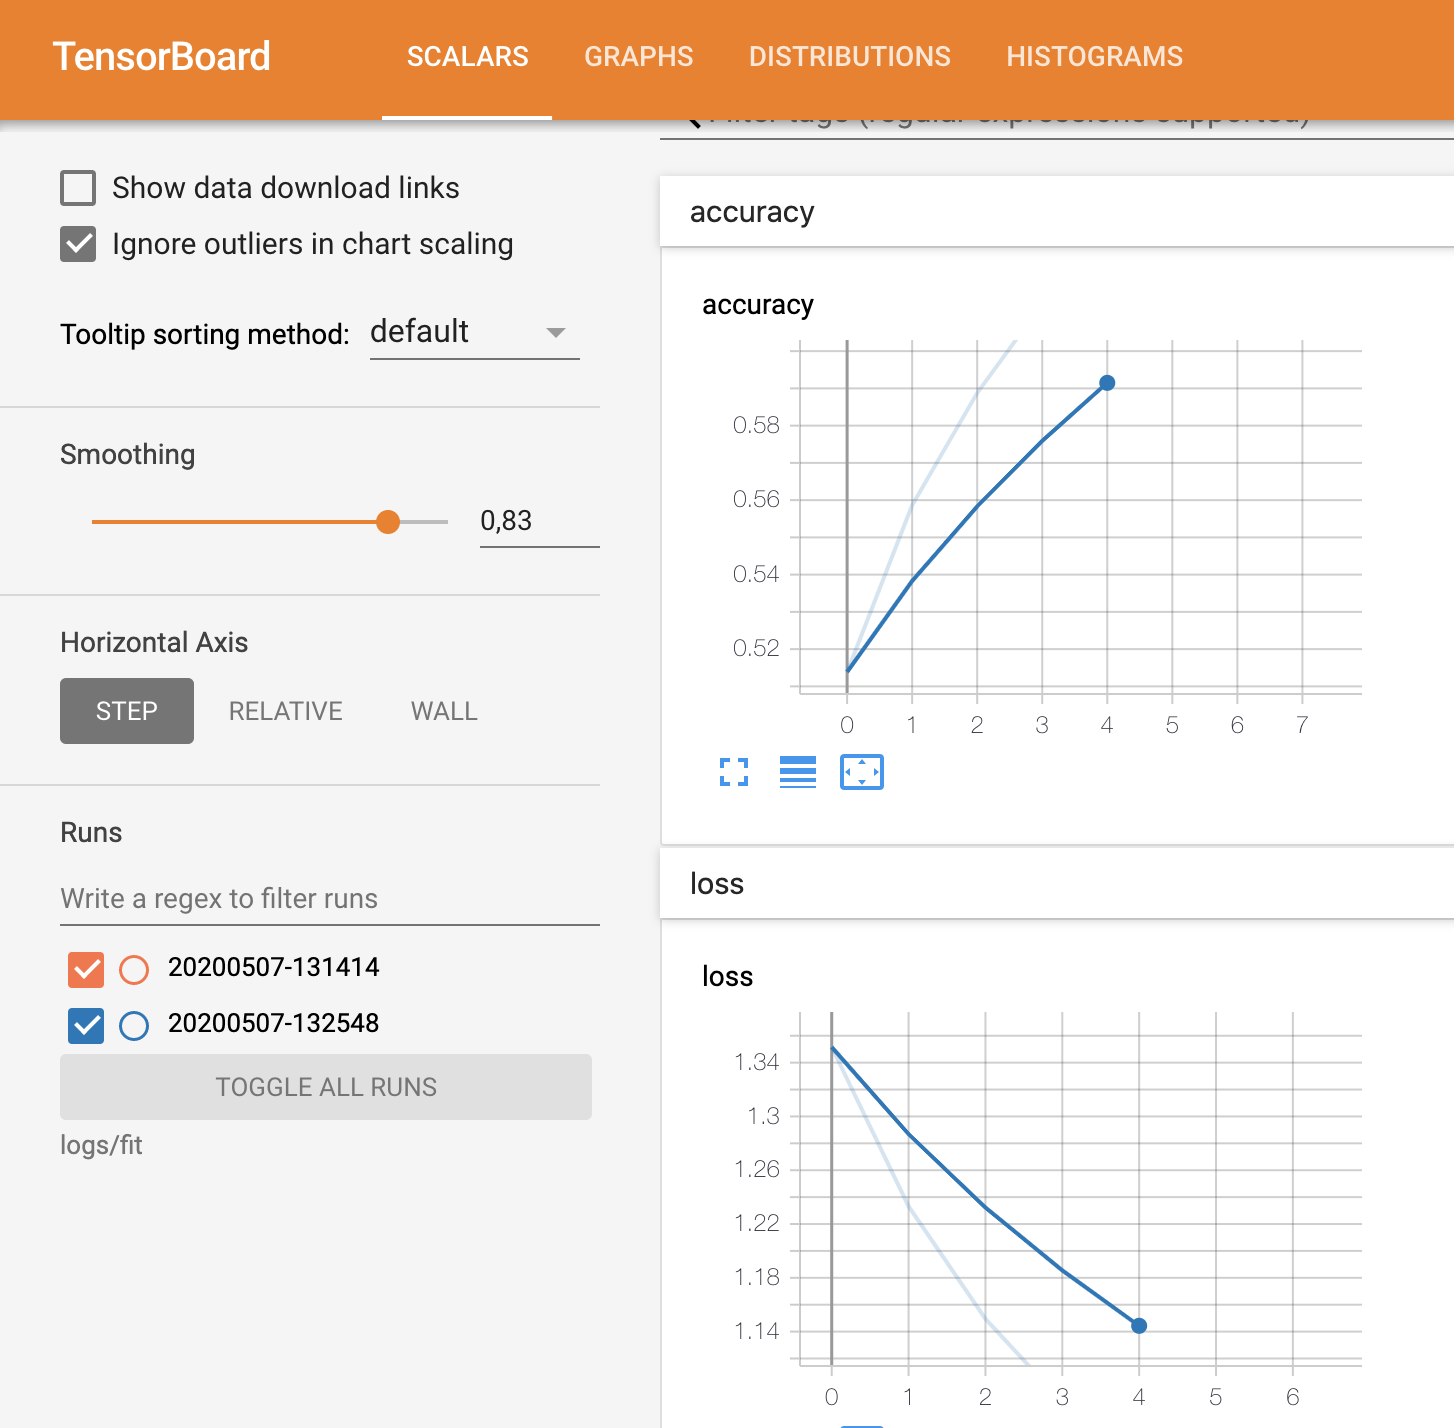

**Сохранение полной модели**

In [29]:
# os.getcwd()
save_dir = os.path.join(os.getcwd(), 'models')
print(save_dir)
model_name = 'modelpkh.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

/Users/paulik/Универ/giis/models
Saved trained model at /Users/paulik/Универ/giis/models/modelpkh.h5 


In [30]:
# Score trained model.
def model_evaluate(model1):
    scores = model1.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

**Проверка точности базовой модели без тренировки**

In [17]:
#Ненатренированная модель
model2 = create_model()
model_evaluate(model2)


10000/10000 [==============================] - 5s 520us/step
Test loss: 2.306235139465332
Test accuracy: 0.09300000220537186


*Точность показала 9%*  
**Теперь создадим базовую модель и загрузим веса из чекпоинтов, полученных в результате обучения**

In [31]:
model_trained = create_model()
model_trained.load_weights(checkpoint_path)
model_evaluate(model_trained)

10000/10000 [==============================] - 6s 579us/step
Test loss: 0.9856774023056031
Test accuracy: 0.6484000086784363


**Точность на тестовой выборке составила 64%**

***Ответы на вопросы:***  
1) tensorboard --logdir logs/fit и далее перейти по ссылке  
2) tf.keras.backend.clear_session() для tfv.2.1  
3) Коллекция - это объект похожий на словарь, в котором мы храним элементы узлов графа.Например, в коллекцию сохраняется переменная измерения точности и входные элементы модели.  
4) Для записи дефолтных метрик:  
*log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")*    
*tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)*  
Для записи дополнительных статистик в цикле итерации эпох используются команды:  
*with train_summary_writer.as_default():*  
    *tf.summary.scalar('loss', train_loss.result(), step=epoch)*  
    *tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)*  
(для выборки обучения, в случае тестовой: *test_summary_writer.as_default()*)  